# LLaMA with FSDP and Tensor Parallelism
In this notebook we provide a simple exmple of using scalax sjit for combining FSDP and tensor parallelism (TP). We train a simple LLaMA transformer model defined in the huggingface transformers library using huggingface datasets. We show that all of these can be done rather easily without modifying the model definition and the tran step function.

In [1]:
from functools import partial

import jax
import jax.numpy as jnp
from flax.training.train_state import TrainState
import optax

import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm, trange

from transformers import FlaxLlamaForCausalLM, LlamaTokenizer, FlaxGemmaForCausalLM, GemmaTokenizer
from datasets import load_dataset

from scalax.utils import JaxRNG
from scalax.sharding import PartitionSpec, MeshShardingHelper, TreePathShardingRule
from scalax.utils import print_pytree_structure

from typing import Any, Callable, Optional

%matplotlib inline

## C4 DataLoader
We use the C4 dataset implemented in the Huggingface datasets library. We create a very simple data loader that tokenizes the text and apply sequnce packing to form batches.

In [2]:
def c4_data_loader(batch_size, seq_length):
    chunk_size = batch_size * seq_length
    # Stream the c4 dataset without downloading
    dataset = load_dataset('allenai/c4', 'en', split='train', streaming=True, trust_remote_code=True)
    # Use the free OpenLLaMA tokenizer
    tokenizer = LlamaTokenizer.from_pretrained('h2oai/h2o-danube3-500m-chat')

    # Use a static mask and position ids here for simplicity
    attention_mask = np.ones((batch_size, seq_length), dtype=np.int32)
    position_ids = np.arange(seq_length, dtype=np.int32).reshape(1, -1)
    position_ids = np.broadcast_to(position_ids, (batch_size, seq_length))
    
    token_buffer = []
    for example in dataset:
        # Sequence packing
        token_buffer.extend(tokenizer.encode(example['text']))
        token_buffer.append(tokenizer.eos_token_id)
        while len(token_buffer) > chunk_size + 1:
            batch = {
                'input_tokens': np.array(
                    token_buffer[:chunk_size], dtype=np.int32
                ).reshape(batch_size, seq_length),  # Input tokens to language model
                'target_tokens': np.array(
                    token_buffer[1:chunk_size + 1], dtype=np.int32
                ).reshape(batch_size, seq_length),  # Shift-by-one training target tokens
                'attention_mask': attention_mask,
                'position_ids': position_ids,
            }
            token_buffer = token_buffer[chunk_size:]
            yield batch        
    

## Inspect the Model Tree Sturcture
To compose FSDP and tensor parallelism, we need to specify which axis should be sharded with fsdp and which axis should be sharded with tp for each tensor. To do this, we need to use `TreePathShardingRule`. `TreePathShardingRule` specifies sharding according to the path of leaf tensors in a pytree, and match it agaist user defined regular expressions. To use it, the fisrt step is to inspect the pytree structure of the model. We can do this with `scalax.utils.print_pytree_structure`.

In [3]:
def load_model() -> tuple[Callable, dict]:
    with jax.default_device(jax.devices('cpu')[0]):
        model = FlaxLlamaForCausalLM.from_pretrained('h2oai/h2o-danube3-500m-chat')
        forward = model.__call__
        params = model.params
    return forward, params


forward, params = load_model()

print_pytree_structure(params)

Some of the weights of FlaxLlamaForCausalLM were initialized in bfloat16 precision from the model checkpoint at h2oai/h2o-danube3-500m-chat:
[('lm_head', 'kernel'), ('model', 'embed_tokens', 'embedding'), ('model', 'layers', '0', 'input_layernorm', 'weight'), ('model', 'layers', '0', 'mlp', 'down_proj', 'kernel'), ('model', 'layers', '0', 'mlp', 'gate_proj', 'kernel'), ('model', 'layers', '0', 'mlp', 'up_proj', 'kernel'), ('model', 'layers', '0', 'post_attention_layernorm', 'weight'), ('model', 'layers', '0', 'self_attn', 'k_proj', 'kernel'), ('model', 'layers', '0', 'self_attn', 'o_proj', 'kernel'), ('model', 'layers', '0', 'self_attn', 'q_proj', 'kernel'), ('model', 'layers', '0', 'self_attn', 'v_proj', 'kernel'), ('model', 'layers', '1', 'input_layernorm', 'weight'), ('model', 'layers', '1', 'mlp', 'down_proj', 'kernel'), ('model', 'layers', '1', 'mlp', 'gate_proj', 'kernel'), ('model', 'layers', '1', 'mlp', 'up_proj', 'kernel'), ('model', 'layers', '1', 'post_attention_layernorm', 

lm_head/kernel: shape: (1536, 32000), dtype: bfloat16
model/embed_tokens/embedding: shape: (32000, 1536), dtype: bfloat16
model/layers/0/input_layernorm/weight: shape: (1536,), dtype: bfloat16
model/layers/0/mlp/down_proj/kernel: shape: (4096, 1536), dtype: bfloat16
model/layers/0/mlp/gate_proj/kernel: shape: (1536, 4096), dtype: bfloat16
model/layers/0/mlp/up_proj/kernel: shape: (1536, 4096), dtype: bfloat16
model/layers/0/post_attention_layernorm/weight: shape: (1536,), dtype: bfloat16
model/layers/0/self_attn/k_proj/kernel: shape: (1536, 768), dtype: bfloat16
model/layers/0/self_attn/o_proj/kernel: shape: (1536, 1536), dtype: bfloat16
model/layers/0/self_attn/q_proj/kernel: shape: (1536, 1536), dtype: bfloat16
model/layers/0/self_attn/v_proj/kernel: shape: (1536, 768), dtype: bfloat16
model/layers/1/input_layernorm/weight: shape: (1536,), dtype: bfloat16
model/layers/1/mlp/down_proj/kernel: shape: (4096, 1536), dtype: bfloat16
model/layers/1/mlp/gate_proj/kernel: shape: (1536, 4096)

# Define the Mesh Sharding Rule
According to the previous pytree structure, we define the following mesh and sharding rule. We employ 2-way tensor parallelism and use the rest for FSDP.

In [4]:
mesh = MeshShardingHelper([-1, 2], ['fsdp', 'tp'])

# Use pairs of regex, PartitionSpec to specify the sharding
model_sharding_rule = TreePathShardingRule(
    ('embedding', PartitionSpec('fsdp', 'tp')),
    ('lm_head/kernel', PartitionSpec('tp', 'fsdp')),
    # Megatron style feedfoward sharding
    ('mlp/(up|gate)_proj/kernel', PartitionSpec('fsdp', 'tp')),
    ('mlp/down_proj/kernel', PartitionSpec('tp', 'fsdp')),
    # Attention should be sharded by heads
    ('self_attn/(k|q|v)_proj/kernel', PartitionSpec('fsdp', 'tp')),
    ('self_attn/o_proj/kernel', PartitionSpec('tp', 'fsdp')),
    ('norm', PartitionSpec()),
)

# Inspect the sharding rule can be successfully applied
model_sharding_rule.apply(params)

{'lm_head': {'kernel': PartitionSpec('tp', 'fsdp')},
 'model': {'embed_tokens': {'embedding': PartitionSpec('fsdp', 'tp')},
  'layers': {'0': {'input_layernorm': {'weight': PartitionSpec()},
    'mlp': {'down_proj': {'kernel': PartitionSpec('tp', 'fsdp')},
     'gate_proj': {'kernel': PartitionSpec('fsdp', 'tp')},
     'up_proj': {'kernel': PartitionSpec('fsdp', 'tp')}},
    'post_attention_layernorm': {'weight': PartitionSpec()},
    'self_attn': {'k_proj': {'kernel': PartitionSpec('fsdp', 'tp')},
     'o_proj': {'kernel': PartitionSpec('tp', 'fsdp')},
     'q_proj': {'kernel': PartitionSpec('fsdp', 'tp')},
     'v_proj': {'kernel': PartitionSpec('fsdp', 'tp')}}},
   '1': {'input_layernorm': {'weight': PartitionSpec()},
    'mlp': {'down_proj': {'kernel': PartitionSpec('tp', 'fsdp')},
     'gate_proj': {'kernel': PartitionSpec('fsdp', 'tp')},
     'up_proj': {'kernel': PartitionSpec('fsdp', 'tp')}},
    'post_attention_layernorm': {'weight': PartitionSpec()},
    'self_attn': {'k_proj

## Sharded Initialization and TrainStep
We define the initialization and train step functions and shard them with the `sjit` method of `MeshShardingHelper`. For model, we use our previously defined sharding rule, and for data, we shard the batch axis with `fsdp`. All of these can be simply specified as arugments to `sjit`, without changing the `init_fn` and `train_step` functions. The `init_fn` and `train_step` functions here are exactly the same as if we are training on a single GPU.

In [5]:
optimizer = optax.adamw(1e-5)
seq_length = 512

@partial(
    mesh.sjit,  # Shard the initialization function
    # The initialized model and optimizer states should be sharded according
    # to our tree path sharding rule
    out_shardings=model_sharding_rule,
)
def init_fn(rng):
    return TrainState.create(params=params, tx=optimizer, apply_fn=None)


@partial(
    mesh.sjit,  # Shard the train step function
    # The input model should be sharded with model_sharding_rule, the data is loaded as replicated
    in_shardings=(model_sharding_rule, PartitionSpec()),
    # The output model should be sharded with model_sharding_rule, the loss metrics is replicated
    out_shardings=(model_sharding_rule, PartitionSpec()),
    # After the beginning of the function, the data should be sharded along the `fsdp` axis
    args_sharding_constraint=(model_sharding_rule, PartitionSpec('fsdp')),
    donate_argnums=(0,),  # No need to preserve the old model
)
def train_step(train_state, batch):
    def loss_fn(params):
        logits = forward(
            input_ids=batch['input_tokens'],
            attention_mask=batch['attention_mask'],
            position_ids=batch['position_ids'],
            params = params,
        ).logits
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits, batch['target_tokens']
        )
        return jnp.mean(loss)
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(train_state.params)
    train_state = train_state.apply_gradients(grads=grads)
    return train_state, loss
    

## Running the Sharded Train Step
Now let's run the sharded train step for 100 steps and plot the loss

  0%|          | 0/100 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

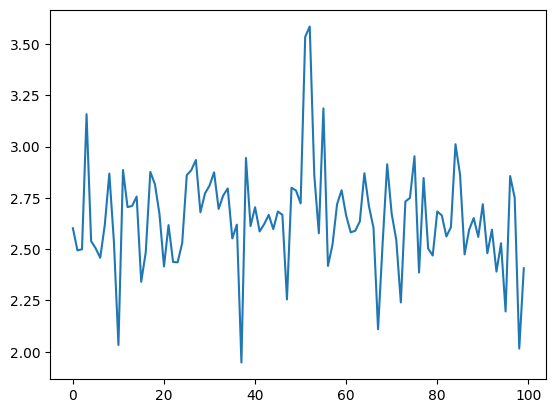

In [6]:
data_iterator = c4_data_loader(8, seq_length)
train_state = init_fn(jax.random.PRNGKey(42))

losses = []
for _, batch in zip(trange(100), data_iterator):
    train_state, loss = train_step(train_state, batch)
    losses.append(loss)

plt.plot(losses)